In [3]:
from astropy.table import Table, vstack
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import numpy as np
import matplotlib 
from RegscorePy import *
from collections import OrderedDict
from radial_distribution_funcs import *
# import pymc3 as pm

plt.rc('font', family='serif'), plt.rc('xtick', labelsize=20), plt.rc('ytick', labelsize=20)
plt.rcParams['savefig.dpi'] = 200
plt.rc('text',usetex=True)
matplotlib.rcParams['xtick.direction'] = 'in'
matplotlib.rcParams['ytick.direction'] = 'in'
np.set_printoptions(precision=3)

### Central catalogs

satellite number / bkg number counts


674 60 614 0.089 9.007659473804484

762 188 574 0.247 8.460891021746285

1453 246 1207 0.169 9.184844806957454

1585 316 1269 0.199 8.303121827399398


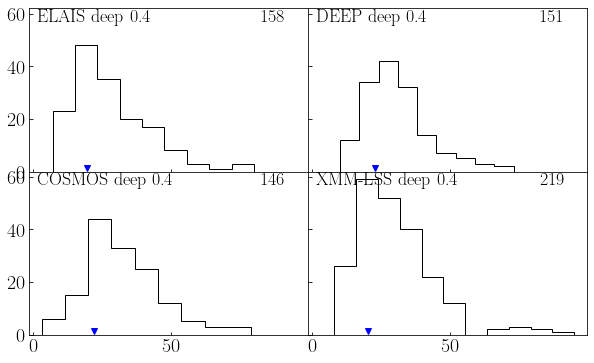

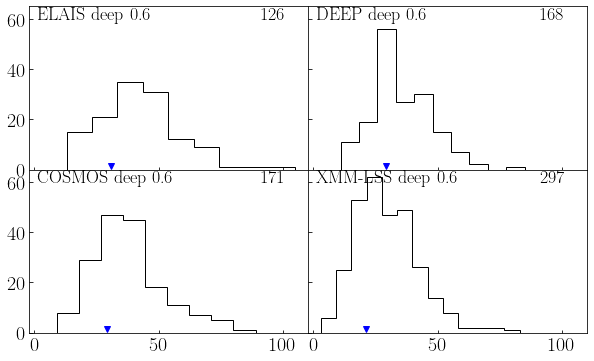

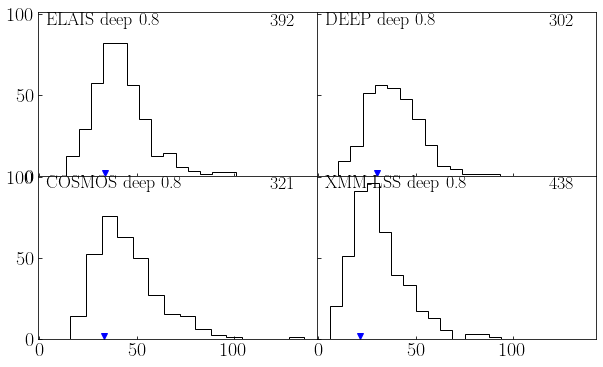

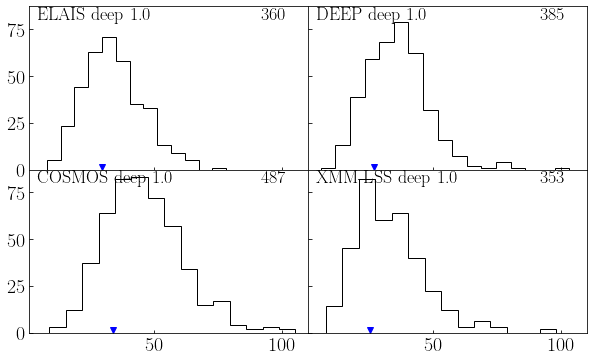

In [31]:
# satellite counts
field_names = ['ELAIS_deep','DEEP_deep','COSMOS_deep','XMM-LSS_deep']
count_sat = []
sat_z_cut=3.0

for z in [0.4,0.6,0.8, 1.0]:
    num_cen = 0
    num_cen_sf = 0
    n_sat = 0
    print('')
    fig, axs = plt.subplots(2, 2, figsize = (10, 6),sharex=True,sharey=True)
    for i,field_name in enumerate(field_names):
        row=i//2; col=i%2
        cat = Table.read('CUT_deep_catalogs/radial_dist_code/central_cat/isolated_'+field_name+'_'+str(sat_z_cut)+'_11.3_'+str(z)+'_massive.positions.fits')
        num_cen_sf += len(cat[cat['sfq_nuvrk']>0.5])
        num_cen += len(cat)
        n_sat += (np.mean(cat['n_sat'])-np.mean(cat['n_bkg']))
        # plot histogram
        axs[row][col].hist(cat['n_sat'],histtype='step',color='k',bins='scott')
        axs[row][col].plot(np.mean(cat['n_bkg']),1.5,'vb')
        
        # annotations
        axs[row][col].annotate(field_name.replace('_',' ')+' '+str(z),xy=([0.03,0.92]),xycoords='axes fraction',fontsize=18)
        axs[row][col].annotate(str(len(cat)),xy=([0.83,0.92]),xycoords='axes fraction',fontsize=18)
    print(num_cen,num_cen_sf,num_cen-num_cen_sf,round(num_cen_sf/num_cen,3),n_sat/4)
    fig.subplots_adjust(hspace=0.0)
    fig.subplots_adjust(wspace=0.0)


#### check q-fraction for centrals (massive gals in general)

In [17]:
# load catalogs
field_names = ['ELAIS_deep','DEEP_deep','COSMOS_deep','XMM-LSS_deep']

for z in [0.4, 0.6, 0.8, 1.0]:
    num_cen = 0
    num_cen_sf = 0
    num_cen_q = 0
    for field in field_names:
        cat = Table.read('clauds_cat_v2020/completeness_useful_params_cat/'+field+'_v9_gal_cut_params_sfq_added.fits')
        if field == 'XMM-LSS_deep':
            cat = cat[cat['inside_uS'] == True]
        else:
            cat = cat[cat['inside_u'] == True]
        cat = cat[cat['MASK'] == 0]  # unmasked
        cat_gal = cat[cat['OBJ_TYPE'] == 0]  # galaxies
    
        cat_massive_gal = cat_gal[np.logical_and(cat_gal['MASS_MED'] > 11.3, cat_gal['MASS_MED'] < 13.0)]
        cat_massive_z_slice = cat_massive_gal[abs(cat_massive_gal['ZPHOT'] - z) < 0.1]
        cat_massive_z_slice_sf = cat_massive_z_slice[cat_massive_z_slice['SSFR_MED']>-11]
        
        num_cen += len(cat_massive_z_slice)
        num_cen_sf += len(cat_massive_z_slice_sf)
        num_cen_q += (len(cat_massive_z_slice) - len(cat_massive_z_slice_sf))
        
    print(num_cen,num_cen_sf,num_cen_q,round(num_cen_sf/num_cen,3))
    

1112 49 1063 0.044
1276 356 920 0.279
2895 1615 1280 0.558
3498 3111 387 0.889


### Stacking satellite and background obj catalogs

In [8]:
# stack the satellite catalogs (all redshift bins)
import glob
path = 'CUT_deep_catalogs/radial_dist_code/total_sample_sfProb_nuvrk/'
# stack_type = 'satellites'
stack_type='background'
print(stack_type)
cat_names = ['COSMOS_deep','ELAIS_deep', 'DEEP_deep','XMM-LSS_deep']
cat_sat_1 = Table.read(path+stack_type+'_ELAIS_deep_0.4.fits')
for z in [0.4,0.6,0.8,1.0]:
    cat_cen = Table(names=cat_sat_1.colnames, dtype=[str(y[0]) for x, y in cat_sat_1.dtype.fields.items()])
    for cat_name in cat_names:
        cat_cen_ind = Table.read(path+stack_type+'_'+cat_name+'_'+str(z)+'.fits')
        cat_cen = vstack([cat_cen,cat_cen_ind])
    cat_cen.write(path+stack_type+'_'+str(z)+'.fits',overwrite=True)

background


### Match mass distribution for sf/q centrals

In [9]:
from scipy.stats import ks_2samp

In [27]:
N_BINS = 100
step = 100 / N_BINS
for z in  [0.4, 0.6, 0.8, 1.0]:
    print('===========')
    for cat_name in ['COSMOS_deep','DEEP_deep','ELAIS_deep','XMM-LSS_deep']:
        path = 'CUT_deep_catalogs/radial_dist_code/central_cat/'
        sf_mass_list = np.array([])
        q_mass_list = np.array([])

        cat_cen = Table.read(path+'isolated_'+cat_name+'_3.0_11.3_'+str(z)+'_massive.positions.fits')
        cat_sf = cat_cen[cat_cen['sfProb_nuvrk']>=0.5]
        cat_q = cat_cen[cat_cen['sfProb_nuvrk']<0.5]
        sf_mass_list = cat_sf['MASS_MED']
        q_mass_list = cat_q['MASS_MED']
        SAMPLE_SIZE=int(len(cat_q)/2)
        print(cat_name,z,len(cat_cen),len(sf_mass_list),len(q_mass_list))

        # match mass distribution of sf/q centrals
        sf_central_percentiles = np.sort(np.array([
            np.percentile(sf_mass_list, percentage, axis=0)
            for percentage in np.arange(start=step, stop=100, step=step)]))

        # Match each observation in the training set to a bin
        q_central_bins = np.digitize(q_mass_list, sf_central_percentiles)

        # Count the number of values in each training set bin
        q_central_bin_counts = np.bincount(q_central_bins)

        # Weight each observation in the training set based on which bin it is in
        weights = 1 / np.array([q_central_bin_counts[x] for x in q_central_bins])

        # Make the weights sum up to 1
        weights_norm = weights / np.sum(weights)
        
        np.random.seed(0)
        cat_q_matched = np.random.choice(cat_q, size=SAMPLE_SIZE, p=weights_norm, replace=False)
        q_mass_list_matched = cat_q_matched['MASS_MED']
        cat_sf.write(path+'/isolated_csf_central_matched_'+cat_name+'_'+str(z)+'.fits',overwrite=True)
        cat_q_matched = Table(names=cat_sf.colnames, dtype=[str(y[0]) for x, y in cat_sf.dtype.fields.items()],data=cat_q_matched) 
        cat_q_matched.write(path+'/isolated_cq_central_matched_'+cat_name+'_'+str(z)+'.fits',overwrite=True)
        print(len(cat_sf),len(cat_q_matched))

COSMOS_deep 0.4 146 16 130
16 65
DEEP_deep 0.4 151 11 140
11 70
ELAIS_deep 0.4 158 6 152
6 76
XMM-LSS_deep 0.4 218 34 184
34 92
COSMOS_deep 0.6 172 32 140
32 70
DEEP_deep 0.6 168 51 117
51 58
ELAIS_deep 0.6 126 21 105
21 52
XMM-LSS_deep 0.6 299 41 258
41 129
COSMOS_deep 0.8 321 26 295
26 147
DEEP_deep 0.8 302 39 263
39 131
ELAIS_deep 0.8 392 32 360
32 180
XMM-LSS_deep 0.8 435 31 404
31 202
COSMOS_deep 1.0 493 46 447
46 223
DEEP_deep 1.0 400 17 383
17 191
ELAIS_deep 1.0 362 21 341
21 170
XMM-LSS_deep 1.0 363 65 298
65 149


### More Info

#### check upturn at large radii

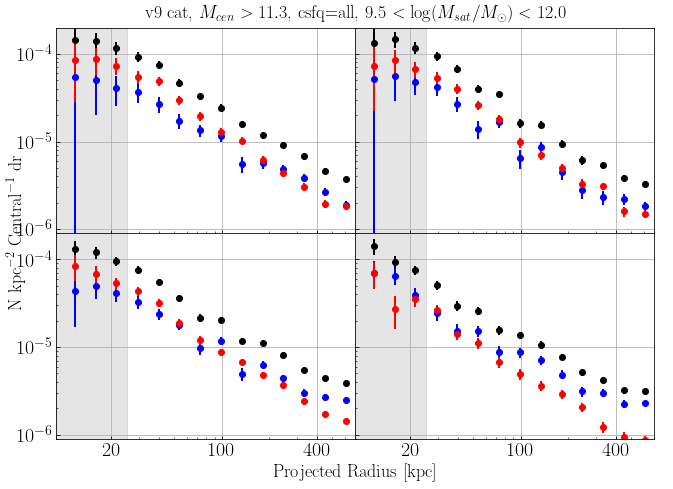

In [12]:
fig, axs = plt.subplots(2, 2, sharex=True, sharey=True, figsize=(10,7))
sample_all=''
csfq='all'
sat_z_cut = 3.0
field_names = ['ELAIS_deep','DEEP_deep','COSMOS_deep','XMM-LSS_deep']
colors = ['k','b','r']
#============= primary data ===========
path = 'CUT_deep_catalogs/radial_dist_code/distribution/total_sample_sfProb_nuvrk/' 
sample_name = r'v9 cat, $M_{cen}>11.3$, csfq='+csfq+', $9.5<\log(M_{sat}/M_\odot)<12.0$'

for i,z in enumerate([0.4,0.6,0.8,1.0]):
    row = i // 2; col = i % 2
    for k,ssfq in enumerate(['all','ssf','sq']):
        count_radial = combine_deep_fields(field_names, csfq, ssfq,'9.5','12.0',z,path,sat_z_cut=sat_z_cut,sample=sample_all)
        bin_edges = np.load(path+'bin_centers.npy')
        #==============plot====================
        axs[row][col].errorbar(bin_edges, count_radial[0],count_radial[1],fmt='o'+colors[k],
                           label=ssfq+' $'+str(round(z-0.1,1))+'<z<'+str(round(z+0.1,1))+'$',linewidth=2)
        axs[row][col].set_yscale('log')
        axs[row][col].set_xscale('log')
    axs[row][col].axvspan(9, 25, alpha=0.1, color='k')
    axs[row][col].set_xticks([20, 100, 400])
    axs[row][col].get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
    axs[row][col].set_xlim([9,700])
    axs[row][col].set_ylim([9e-7,2e-4])
    axs[row][col].grid()
fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
plt.xlabel('Projected Radius [kpc]', fontsize=18)
plt.ylabel('N kpc$^{-2}$ Central$^{-1}$ dr', fontsize=18)
plt.tight_layout()
plt.title(sample_name,fontsize=18)
fig.subplots_adjust(hspace=0)
fig.subplots_adjust(wspace=0)
plt.show() 



### Test / Check Figures


#### combine redshift bin ($$0.3<z<1.1)

In [7]:
# combine redshift bin
sat_z_cut = 3.0
bin_number=14
field_names = ['ELAIS_deep','DEEP_deep','COSMOS_deep','XMM-LSS_deep'] 
field_names = ['COSMOS_deep','XMM-LSS_deep'] # for inside_j
path = 'CUT_deep_catalogs/radial_dist_code/distribution_test/total_sample_sfProb_nuvrk_inside_j/'
masscut_low = '9.5'
masscut_high = '12.0'
csfq='all'
bin_edges = np.load(path+'bin_edges.npy')
bin_centers = bin_edges[:-1] + np.diff(bin_edges)/2

radial_all = np.zeros(bin_number)
radial_all_err_square = np.zeros(bin_number)
radial_ssf = np.zeros(bin_number)
radial_ssf_err_square = np.zeros(bin_number)
radial_sq = np.zeros(bin_number)
radial_sq_err_square = np.zeros(bin_number)
count_all = 0
count_ssf = 0
count_sq = 0

for z in [0.4, 0.6, 0.8, 1.0]:
    radial_z_all = combine_deep_fields(field_names,csfq,'all',masscut_low,masscut_high, z,sat_z_cut=sat_z_cut, path=path, bin_number=bin_number)
    count_all += radial_z_all[2]
    radial_all += radial_z_all[0]*radial_z_all[2]
    radial_all_err_square += radial_z_all[1]**2*radial_z_all[2]**2
        
    radial_z_ssf = combine_deep_fields(field_names,csfq,'ssf',masscut_low,masscut_high, z,sat_z_cut=sat_z_cut, path=path, bin_number=bin_number)
    count_ssf += radial_z_ssf[2]
    radial_ssf += radial_z_ssf[0]*radial_z_ssf[2]
    radial_ssf_err_square += radial_z_ssf[1]**2*radial_z_ssf[2]**2
        
    radial_z_sq = combine_deep_fields(field_names,csfq,'sq',masscut_low,masscut_high, z,sat_z_cut=sat_z_cut, path=path, bin_number=bin_number)
    count_sq += radial_z_sq[2]
    radial_sq += radial_z_sq[0]*radial_z_sq[2]
    radial_sq_err_square += radial_z_sq[1]**2*radial_z_sq[2]**2

radial_all = (radial_all/count_all, np.sqrt(radial_all_err_square)/count_all)
radial_ssf = (radial_ssf/count_ssf, np.sqrt(radial_ssf_err_square)/count_ssf)
radial_sq = (radial_sq/count_sq, np.sqrt(radial_sq_err_square)/count_sq)
print('No. of centrals',count_all)

np.savetxt(path+'all_field_'+str(sat_z_cut)+'_'+masscut_low+'_'+masscut_high+'_'+csfq+'_'+ 'all'+'.txt', radial_all)
np.savetxt(path+'all_field_'+str(sat_z_cut)+'_'+masscut_low+'_'+masscut_high+'_'+csfq+'_'+ 'ssf'+'.txt', radial_ssf)
np.savetxt(path+'all_field_'+str(sat_z_cut)+'_'+masscut_low+'_'+masscut_high+'_'+csfq+'_'+ 'sq'+'.txt', radial_sq)


No. of centrals 714.0


#### sat mass 9.7-12.0

14 15 14 14
nfw+sersic [4.500e+02 1.144e-05 4.899e-05 2.791e+01 2.179e+00] [1.219e+02 3.476e-06 3.435e-05 9.302e+00 2.976e+00] 0.7744187302661976
14 15 14 14
nfw+sersic [2.125e+02 1.277e-05 2.092e-05 6.640e+00 1.899e+00] [1.099e+02 8.002e-06 1.028e-01 1.073e+04 2.085e+03] 9.134662303061523
14 15 14 14
nfw+sersic [3.461e+02 7.335e-06 2.035e-05 3.554e+01 8.670e-01] [1.996e+01 4.741e-07 1.424e-06 1.390e+00 1.475e-01] 0.08435363412663179


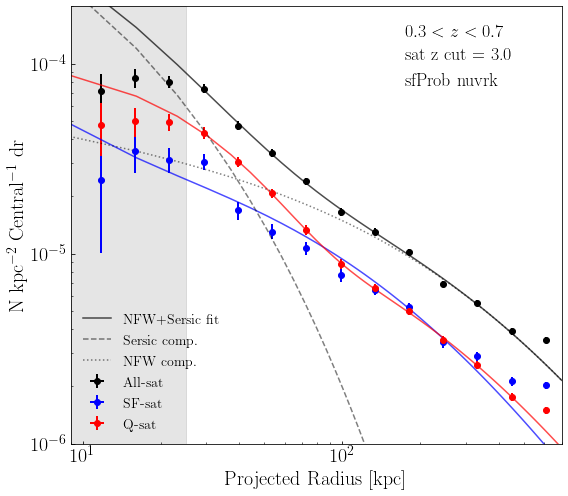

In [24]:
fig, axs = plt.subplots(1, 1, sharex=True,sharey='row', figsize=(8, 7))
sfq_method = 'sfProb_nuvrk'
path = 'CUT_deep_catalogs/radial_dist_code/distribution_test/total_sample_9.7_12.0/'

masscut_low = '9.7'
masscut_high = '12.0'
csfq='all'
sat_z_cut = 3.0
start=4
bin_edges = np.load(path+'bin_edges.npy')
bin_centers = np.load(path+'bin_centers_fixed.npy')
minus = bin_centers - bin_edges[:-1]
plus = bin_edges[1:] - bin_centers
color=['k','b','r']
sat_type = ['All','SF','Q']
fit_x = np.linspace(2,700,num=100)

count_radial_allz = np.genfromtxt(path+'all_field_'+str(sat_z_cut)+'_'+masscut_low+'_'+masscut_high+'_all_'+ 'all'+'.txt')
count_radial_sf_allz = np.genfromtxt(path+'all_field_'+str(sat_z_cut)+'_'+masscut_low+'_'+masscut_high+'_all_'+ 'ssf'+'.txt')
count_radial_q_allz = np.genfromtxt(path+'all_field_'+str(sat_z_cut)+'_'+masscut_low+'_'+masscut_high+'_all_'+ 'sq'+'.txt')
########
for i, radial in enumerate([count_radial_allz,count_radial_sf_allz,count_radial_q_allz]):
    label='NFW+Sersic fit' if i==0 else ''
    print(len(bin_centers),len(bin_edges),len(radial[0]),len(radial[1]))
    plt.errorbar(bin_centers, radial[0],yerr=radial[1],xerr=0,fmt='o'+color[i],label=sat_type[i]+'-sat',linewidth=2)
    
    popt_allz,pcov_allz,chi2_allz = fit_nfw_sersic(bin_centers,radial[0],radial[1], 4)
    perr_allz = np.sqrt(np.diag(pcov_allz))
    print('nfw+sersic',popt_allz,perr_allz,chi2_allz/(len(bin_edges)-start+1 - len(popt_allz)))
    plt.plot(fit_x,nfw_sersic(fit_x, popt_allz[0],popt_allz[1],popt_allz[2],popt_allz[3],popt_allz[4]),color[i],alpha=0.7,label=label)
        
popt_allz,pcov_allz,chi2_allz = fit_nfw_sersic(bin_centers,count_radial_allz[0],count_radial_allz[1], 4)
plt.plot(fit_x,sersic(fit_x, popt_allz[2],popt_allz[3],popt_allz[4]),'--k',alpha=0.5,label='Sersic comp.')
plt.plot(fit_x,nfw(fit_x,popt_allz[0],popt_allz[1]),':k',alpha=0.5,label='NFW comp.')
plt.annotate(r'$0.3<z<1.1$',xy=([0.68,0.93]),xycoords='axes fraction',fontsize=18,color='k')
plt.annotate('sat z cut = '+str(sat_z_cut),xy=([0.68,0.88]),xycoords='axes fraction',fontsize=18,color='k')
plt.annotate(sfq_method.replace('_',' '),xy=([0.68,0.82]),xycoords='axes fraction',fontsize=18,color='k')

plt.axvspan(9, 25, alpha=0.1, color='k')
plt.xscale('log')
plt.yscale('log')
plt.xlim([9,700])
plt.ylim([1e-6,2e-4])
plt.xlabel('Projected Radius [kpc]', fontsize=20)
plt.ylabel('N kpc$^{-2}$ Central$^{-1}$ dr', fontsize=20)
plt.legend(fontsize=14,frameon=False,loc='lower left')
plt.tight_layout()

#### radius 10-800 kpc (10-900)

14 15 14 14
nfw+sersic [1.000e+03 7.173e-06 2.016e-05 5.798e+01 3.798e+00] [1.360e+03 1.025e-05 1.125e-04 1.921e+02 1.797e+01] 4.73262882649697
14 15 14 14
nfw+sersic [1.000e+03 4.307e-06 3.407e-05 2.498e+01 4.371e+00] [1.033e+03 4.300e-06 2.623e-04 8.912e+01 4.774e+01] 3.9668134906066386
14 15 14 14
nfw+sersic [1.000e+03 2.724e-06 4.886e-06 1.053e+02 4.999e+00] [1.894e+03 6.316e-06 4.926e-05 6.360e+02 2.147e+01] 1.4864139336063817


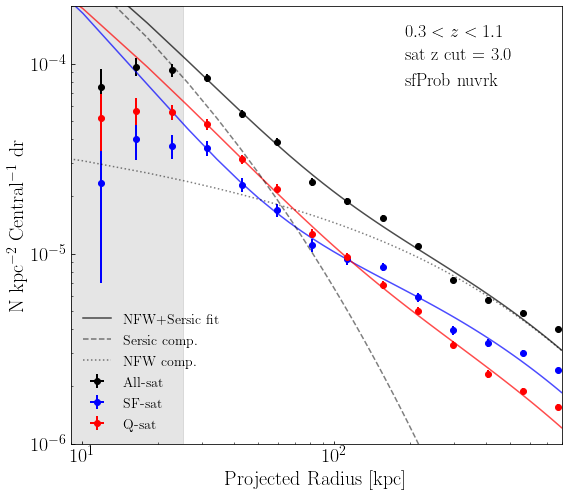

In [37]:
fig, axs = plt.subplots(1, 1, sharex=True,sharey='row', figsize=(8, 7))
sfq_method = 'sfProb_nuvrk'
path = 'CUT_deep_catalogs/radial_dist_code/distribution_test/total_sample_900kpc/'

masscut_low = '9.5'
masscut_high = '12.0'
csfq='all'
sat_z_cut = 3.0
start=4
bin_edges = np.load(path+'bin_edges.npy')
bin_centers = np.load(path+'bin_centers_fixed.npy')
minus = bin_centers - bin_edges[:-1]
plus = bin_edges[1:] - bin_centers
color=['k','b','r']
sat_type = ['All','SF','Q']
fit_x = np.linspace(2,800,num=100)

count_radial_allz = np.genfromtxt(path+'all_field_'+str(sat_z_cut)+'_'+masscut_low+'_'+masscut_high+'_all_'+ 'all'+'.txt')
count_radial_sf_allz = np.genfromtxt(path+'all_field_'+str(sat_z_cut)+'_'+masscut_low+'_'+masscut_high+'_all_'+ 'ssf'+'.txt')
count_radial_q_allz = np.genfromtxt(path+'all_field_'+str(sat_z_cut)+'_'+masscut_low+'_'+masscut_high+'_all_'+ 'sq'+'.txt')
########
for i, radial in enumerate([count_radial_allz,count_radial_sf_allz,count_radial_q_allz]):
    label='NFW+Sersic fit' if i==0 else ''
    print(len(bin_centers),len(bin_edges),len(radial[0]),len(radial[1]))
    plt.errorbar(bin_centers, radial[0],yerr=radial[1],xerr=0,fmt='o'+color[i],label=sat_type[i]+'-sat',linewidth=2)
    
    popt_allz,pcov_allz,chi2_allz = fit_nfw_sersic(bin_centers,radial[0],radial[1], 4)
    perr_allz = np.sqrt(np.diag(pcov_allz))
    print('nfw+sersic',popt_allz,perr_allz,chi2_allz/(len(bin_edges)-start+1 - len(popt_allz)))
    plt.plot(fit_x,nfw_sersic(fit_x, popt_allz[0],popt_allz[1],popt_allz[2],popt_allz[3],popt_allz[4]),color[i],alpha=0.7,label=label)
        
popt_allz,pcov_allz,chi2_allz = fit_nfw_sersic(bin_centers,count_radial_allz[0],count_radial_allz[1], 4)
plt.plot(fit_x,sersic(fit_x, popt_allz[2],popt_allz[3],popt_allz[4]),'--k',alpha=0.5,label='Sersic comp.')
plt.plot(fit_x,nfw(fit_x,popt_allz[0],popt_allz[1]),':k',alpha=0.5,label='NFW comp.')
plt.annotate(r'$0.3<z<1.1$',xy=([0.68,0.93]),xycoords='axes fraction',fontsize=18,color='k')
plt.annotate('sat z cut = '+str(sat_z_cut),xy=([0.68,0.88]),xycoords='axes fraction',fontsize=18,color='k')
plt.annotate(sfq_method.replace('_',' '),xy=([0.68,0.82]),xycoords='axes fraction',fontsize=18,color='k')

plt.axvspan(9, 25, alpha=0.1, color='k')
plt.xscale('log')
plt.yscale('log')
plt.xlim([9,800])
plt.ylim([1e-6,2e-4])
plt.xlabel('Projected Radius [kpc]', fontsize=20)
plt.ylabel('N kpc$^{-2}$ Central$^{-1}$ dr', fontsize=20)
plt.legend(fontsize=14,frameon=False,loc='lower left')
plt.tight_layout()

#### compare sat_z_cut

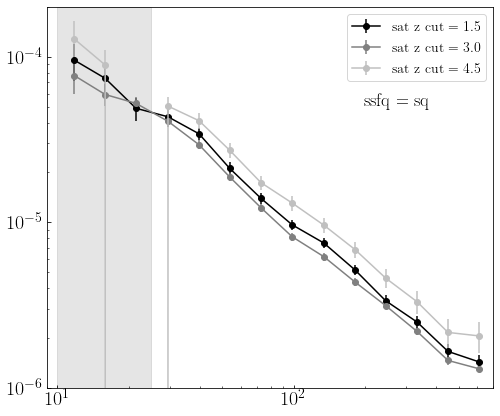

In [21]:
fig, axs = plt.subplots(1, 1, sharex=True,sharey='row', figsize=(8, 7))
masscut_low='9.5'
masscut_high='12.0'
# panel 1
path = 'CUT_deep_catalogs/radial_dist_code/distribution/total_sample_sfProb_nuvrk/'  # evolving mass cut
ssfq = 'sq'
bin_centers = np.load(path+'bin_centers.npy')

# split z
# radial_15 = combine_deep_fields(field_names,'all',ssfq,'9.5','12.0', 0.4,sat_z_cut=1.5, path=path)
# radial_30 = combine_deep_fields(field_names,'all',ssfq,'9.5','12.0', 0.4,sat_z_cut=3.0, path=path)
# radial_45 = combine_deep_fields(field_names,'all',ssfq,'9.5','12.0', 0.4,sat_z_cut=4.5, path=path)

# all z
radial_15 = np.loadtxt(path+'all_field_1.5_'+masscut_low+'_'+masscut_high+'_'+ 'all'+'_'+ssfq+'.txt')
radial_30 = np.loadtxt(path+'all_field_3.0_'+masscut_low+'_'+masscut_high+'_'+ 'all'+'_'+ssfq+'.txt')
radial_45 = np.loadtxt(path+'all_field_4.5_'+masscut_low+'_'+masscut_high+'_'+ 'all'+'_'+ssfq+'.txt')

plt.errorbar(bin_centers, radial_15[0],yerr=radial_15[1],fmt='o-',color='black',label='sat z cut = 1.5')
plt.errorbar(bin_centers, radial_30[0],yerr=radial_30[1],fmt='o-',color='gray',label='sat z cut = 3.0')
plt.errorbar(bin_centers, radial_45[0],yerr=radial_45[1],fmt='o-',color='silver',label='sat z cut = 4.5')
plt.annotate('ssfq = '+ssfq,xy=([0.71,0.74]),xycoords='axes fraction',fontsize=18,color='k')

plt.axhline(2e-5,10,700,linewidth=4, color='r')
plt.axvspan(10, 25, alpha=0.1, color='k')
plt.legend(fontsize=14)
plt.xlim([9,700])
plt.ylim([1e-6,2e-4])
plt.xscale('log')
plt.yscale('log')

#### compare sfq_method

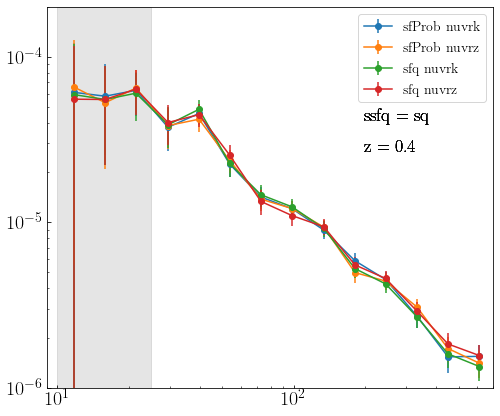

In [15]:
fig, axs = plt.subplots(1, 1, sharex=True,sharey='row', figsize=(8, 7))
sfq_methods = ['sfProb_nuvrk','sfProb_nuvrz','sfq_nuvrk','sfq_nuvrz']
ssfq = 'sq'
bin_centers = np.load(path+'bin_centers.npy')
z = 0.4

for sfq_method in sfq_methods:
    path = 'CUT_deep_catalogs/radial_dist_code/distribution/total_sample_'+sfq_method+'/'  # evolving mass cut
    radial = combine_deep_fields(field_names,'all',ssfq,'9.5','12.0', z,sat_z_cut=1.5, path=path)
    plt.errorbar(bin_centers, radial[0],yerr=radial[1],fmt='o-',label=sfq_method.replace('_',' '))
    plt.annotate('ssfq = '+ssfq,xy=([0.71,0.70]),xycoords='axes fraction',fontsize=18,color='k')
    plt.annotate('z = '+str(z),xy=([0.71,0.62]),xycoords='axes fraction',fontsize=18,color='k')

plt.axhline(2e-5,10,700,linewidth=4, color='r')
plt.axvspan(10, 25, alpha=0.1, color='k')
plt.legend(fontsize=14)
plt.xlim([9,700])
plt.ylim([1e-6,2e-4])
plt.xscale('log')
plt.yscale('log')

#### compare cen mass cut

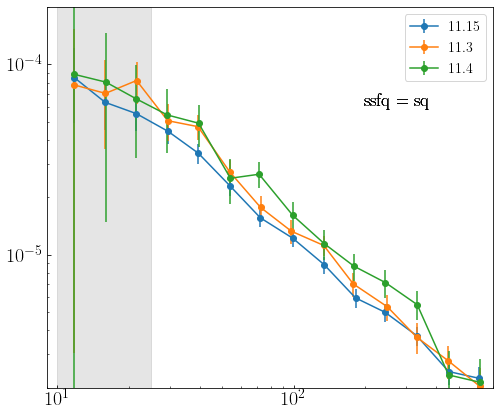

In [20]:
fig, axs = plt.subplots(1, 1, sharex=True,sharey='row', figsize=(8, 7))
cen_mass_limits = [11.15,11.3,11.4]
cen_mass_limits_names = ['cenmass_1115','cenmass_113','cenmass_114']
ssfq = 'sq'
sfq_method = 'sfProb_nuvrk'

for i,cen_mass_limit in enumerate(cen_mass_limits):
    path = 'CUT_deep_catalogs/radial_dist_code/distribution/total_sample_'+sfq_method+cen_mass_limits_names[i]+'/'  # evolving mass cut
    bin_centers = np.load(path+'bin_centers.npy')
    
    radial = combine_deep_fields(field_names,'all',ssfq,'9.5','12.0', 0.4, sat_z_cut=3.0, path=path)
    plt.errorbar(bin_centers, radial[0],yerr=radial[1],fmt='o-',label=str(cen_mass_limit))
    plt.annotate('ssfq = '+ssfq,xy=([0.71,0.74]),xycoords='axes fraction',fontsize=18,color='k')

plt.axhline(2e-5,10,700,linewidth=4, color='r')
plt.axvspan(10, 25, alpha=0.1, color='k')
plt.legend(fontsize=14)
plt.xlim([9,700])
plt.ylim([2e-6,2e-4])
plt.xscale('log')
plt.yscale('log')

#### 18bin, 20bin, 22bin

20 21 20 20
nfw+sersic [4.500e+02 1.059e-05 2.152e-05 3.972e+01 1.380e+00] [1.255e+02 3.260e-06 9.217e-06 1.245e+01 1.077e+00] 1.6748495254738605
20 21 20 20
nfw+sersic [3.136e+02 8.703e-06 1.566e-04 8.722e+00 1.717e+00] [6.954e+01 2.101e-06 3.475e-03 7.155e+01 1.432e+01] 2.5931713187549903
20 21 20 20
nfw+sersic [2.430e+02 9.223e-06 1.568e-05 3.458e+01 4.589e-01] [3.343e+01 1.518e-06 2.766e-06 3.115e+00 2.122e-01] 1.1819138650481398


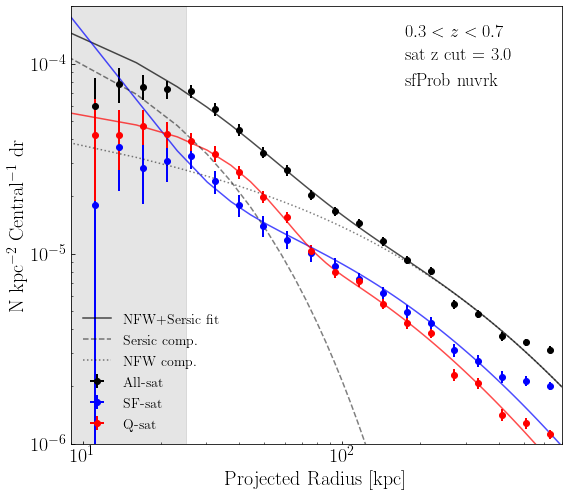

In [5]:
fig, axs = plt.subplots(1, 1, figsize=(8, 7))
sfq_method = 'sfProb_nuvrk'
path = 'CUT_deep_catalogs/radial_dist_code/distribution/total_sample_'+sfq_method+'_20bin/'

masscut_low = '9.5'
masscut_high = '12.0'
csfq='all'
sat_z_cut = 3.0
start=4
bin_edges = np.load(path+'bin_edges.npy')
bin_centers = np.load(path+'bin_centers_fixed.npy')
minus = bin_centers - bin_edges[:-1]
plus = bin_edges[1:] - bin_centers


color=['k','b','r']
sat_type = ['All','SF','Q']
fit_x = np.linspace(2,700,num=100)

count_radial_allz = np.genfromtxt(path+'all_field_'+str(sat_z_cut)+'_'+masscut_low+'_'+masscut_high+'_all_'+ 'all'+'.txt')
count_radial_sf_allz = np.genfromtxt(path+'all_field_'+str(sat_z_cut)+'_'+masscut_low+'_'+masscut_high+'_all_'+ 'ssf'+'.txt')
count_radial_q_allz = np.genfromtxt(path+'all_field_'+str(sat_z_cut)+'_'+masscut_low+'_'+masscut_high+'_all_'+ 'sq'+'.txt')

########
for i, radial in enumerate([count_radial_allz,count_radial_sf_allz,count_radial_q_allz]):
    label='NFW+Sersic fit' if i==0 else ''
    plt.errorbar(bin_centers, radial[0],yerr=radial[1],xerr=0,fmt='o'+color[i],label=sat_type[i]+'-sat',linewidth=2)
    
    popt_allz,pcov_allz,chi2_allz = fit_nfw_sersic(bin_centers,radial[0],radial[1], 4)
    perr_allz = np.sqrt(np.diag(pcov_allz))
    print('nfw+sersic',popt_allz,perr_allz,chi2_allz/(len(bin_edges)-start+1 - len(popt_allz)))
    plt.plot(fit_x,nfw_sersic(fit_x, popt_allz[0],popt_allz[1],popt_allz[2],popt_allz[3],popt_allz[4]),color[i],alpha=0.7,label=label)
        
popt_allz,pcov_allz,chi2_allz = fit_nfw_sersic(bin_centers,count_radial_allz[0],count_radial_allz[1], 4)
plt.plot(fit_x,sersic(fit_x, popt_allz[2],popt_allz[3],popt_allz[4]),'--k',alpha=0.5,label='Sersic comp.')
plt.plot(fit_x,nfw(fit_x,popt_allz[0],popt_allz[1]),':k',alpha=0.5,label='NFW comp.')

plt.annotate(r'$0.3<z<0.7$',xy=([0.68,0.93]),xycoords='axes fraction',fontsize=18,color='k')
plt.annotate('sat z cut = '+str(sat_z_cut),xy=([0.68,0.88]),xycoords='axes fraction',fontsize=18,color='k')
plt.annotate(sfq_method.replace('_',' '),xy=([0.68,0.82]),xycoords='axes fraction',fontsize=18,color='k')

plt.axvspan(9, 25, alpha=0.1, color='k')
plt.xscale('log')
plt.yscale('log')
plt.xlim([9,700])
plt.ylim([1e-6,2e-4])
plt.xlabel('Projected Radius [kpc]', fontsize=20)
plt.ylabel('N kpc$^{-2}$ Central$^{-1}$ dr', fontsize=20)
plt.legend(fontsize=14,frameon=False,loc='lower left')
plt.tight_layout()


#### compare total sample, inside_J, and COSMOS only

nfw+sersic [2.670e+02 2.459e-05 4.477e-05 3.868e+01 7.782e-01] [9.064e+01 1.009e-05 1.429e-05 7.787e+00 6.799e-01] 0.7974396761443524
nfw+sersic [3.009e+02 1.009e-05 2.047e-05 3.415e+01 2.207e+00] [4.169e+02 1.852e-05 5.073e-05 6.035e+01 1.179e+01] 0.5373870718092498
nfw+sersic [2.542e+02 1.357e-05 2.763e-05 4.035e+01 5.788e-01] [6.332e+01 4.096e-06 6.199e-06 4.793e+00 3.331e-01] 0.4467176236532819


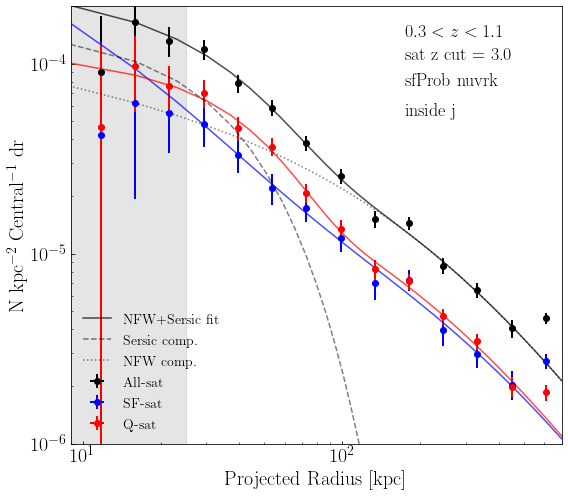

In [11]:
# overall 0.3<z<1.1 plot for inside_j

fig, axs = plt.subplots(1, 1, sharex=True,sharey='row', figsize=(8, 7))
sfq_method = 'sfProb_nuvrk'
path = 'CUT_deep_catalogs/radial_dist_code/distribution_test/total_sample_'+sfq_method+'_inside_j/'
masscut_low = '9.5'
masscut_high = '12.0'
csfq='all'
sat_z_cut = 3.0
bin_edges = np.load(path+'bin_edges.npy')
bin_centers = np.load(path+'bin_centers_fixed.npy')
minus = bin_centers - bin_edges[:-1]
plus = bin_edges[1:] - bin_centers

start=4
color=['k','b','r']
sat_type = ['All','SF','Q']
fit_x = np.linspace(2,700,num=100)
count_radial_allz = np.genfromtxt(path+'all_field_'+str(sat_z_cut)+'_'+masscut_low+'_'+masscut_high+'_all_'+ 'all'+'.txt')
count_radial_sf_allz = np.genfromtxt(path+'all_field_'+str(sat_z_cut)+'_'+masscut_low+'_'+masscut_high+'_all_'+ 'ssf'+'.txt')
count_radial_q_allz = np.genfromtxt(path+'all_field_'+str(sat_z_cut)+'_'+masscut_low+'_'+masscut_high+'_all_'+ 'sq'+'.txt')

########
for i, radial in enumerate([count_radial_allz, count_radial_sf_allz, count_radial_q_allz]):
    label='NFW+Sersic fit' if i==0 else ''
    plt.errorbar(bin_centers, radial[0],yerr=radial[1],xerr=0,fmt='o'+color[i],label=sat_type[i]+'-sat',linewidth=2)
    
    popt_allz,pcov_allz,chi2_allz = fit_nfw_sersic(bin_centers,radial[0],radial[1], 4)
    perr_allz = np.sqrt(np.diag(pcov_allz))
    print('nfw+sersic',popt_allz,perr_allz,chi2_allz/(len(bin_edges)-start+1 - len(popt_allz)))
    plt.plot(fit_x,nfw_sersic(fit_x, popt_allz[0],popt_allz[1],popt_allz[2],popt_allz[3],popt_allz[4]),color[i],alpha=0.7,label=label)
        
popt_allz,pcov_allz,chi2_allz = fit_nfw_sersic(bin_centers,count_radial_allz[0],count_radial_allz[1], 4)
plt.plot(fit_x,sersic(fit_x, popt_allz[2],popt_allz[3],popt_allz[4]),'--k',alpha=0.5,label='Sersic comp.')
plt.plot(fit_x,nfw(fit_x,popt_allz[0],popt_allz[1]),':k',alpha=0.5,label='NFW comp.')
        
plt.annotate(r'$0.3<z<1.1$',xy=([0.68,0.93]),xycoords='axes fraction',fontsize=18,color='k')
plt.annotate('sat z cut = '+str(sat_z_cut),xy=([0.68,0.88]),xycoords='axes fraction',fontsize=18,color='k')
plt.annotate(sfq_method.replace('_',' '),xy=([0.68,0.82]),xycoords='axes fraction',fontsize=18,color='k')
plt.annotate('inside j',xy=([0.68,0.75]),xycoords='axes fraction',fontsize=18,color='k')

plt.axvspan(9, 25, alpha=0.1, color='k')
plt.xscale('log')
plt.yscale('log')
plt.xlim([9,700])
plt.ylim([1e-6,2e-4])
plt.xlabel('Projected Radius [kpc]', fontsize=20)
plt.ylabel('N kpc$^{-2}$ Central$^{-1}$ dr', fontsize=20)
plt.legend(fontsize=14,frameon=False,loc='lower left')
plt.tight_layout()

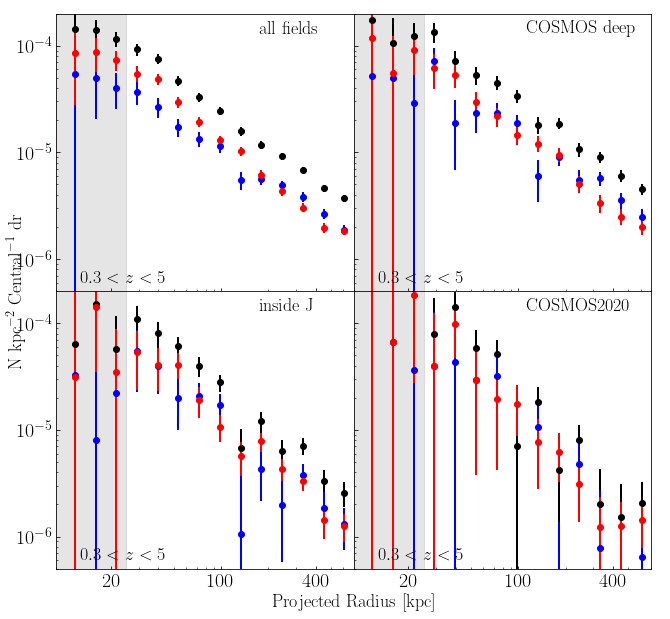

In [7]:
# 4 panel plot
fig, axs = plt.subplots(2, 2, sharex=True,sharey=True, figsize=(10, 9))

z=0.4
masscut_low = '9.5'
masscut_high = '12.0'
csfq='all'
sat_z_cut = 3.0
start=4
bin_number=14
color=['k','b','r']
sat_type = ['All','SF','Q']

path_bin_edges = 'CUT_deep_catalogs/radial_dist_code/distribution/total_sample_sfProb_nuvrk/'
bin_edges = np.load(path_bin_edges+'bin_edges.npy')
bin_centers = np.load(path_bin_edges+'bin_centers_fixed.npy')

path_list = ['distribution/total_sample_sfProb_nuvrk/',
             'distribution/total_sample_sfProb_nuvrk/',
             'distribution_test/total_sample_inside_j/',
             'distribution_test/total_sample_cosmos2020/']

# panel 1
field_names = ['ELAIS_deep','DEEP_deep','COSMOS_deep','XMM-LSS_deep']
path = 'CUT_deep_catalogs/radial_dist_code/distribution/total_sample_sfProb_nuvrk/'
count_radial_allz = combine_deep_fields(field_names,'all','all',masscut_low,masscut_high, z,sat_z_cut=sat_z_cut, path=path, bin_number=bin_number)
count_radial_sf_allz = combine_deep_fields(field_names,'all','ssf',masscut_low,masscut_high, z,sat_z_cut=sat_z_cut, path=path, bin_number=bin_number)
count_radial_q_allz = combine_deep_fields(field_names,'all','sq',masscut_low,masscut_high, z,sat_z_cut=sat_z_cut, path=path, bin_number=bin_number)
axs[0][0].axvspan(9, 25, alpha=0.1, color='k')
axs[0][0].annotate(r'$0.3<z<5$',xy=([0.08,0.03]),xycoords='axes fraction',fontsize=18,color='k')
axs[0][0].annotate('all fields',xy=([0.68,0.93]),xycoords='axes fraction',fontsize=18,color='k')
for i, radial in enumerate([count_radial_allz,count_radial_sf_allz,count_radial_q_allz]):
    axs[0][0].errorbar(bin_centers, radial[0],yerr=radial[1],xerr=0,fmt='o'+color[i],label=sat_type[i]+'-sat',linewidth=2)
    
    
# panel 2
field_names = ['ELAIS_deep','DEEP_deep','COSMOS_deep','XMM-LSS_deep']
path = 'CUT_deep_catalogs/radial_dist_code/distribution/total_sample_sfProb_nuvrk/'
count_radial_allz = load_deep('COSMOS_deep', 'all', 'all', masscut_low, masscut_high, sat_z_cut, z, path=path, sample='')
count_radial_sf_allz = load_deep('COSMOS_deep', 'all', 'ssf', masscut_low, masscut_high, sat_z_cut, z, path=path, sample='')
count_radial_q_allz = load_deep('COSMOS_deep', 'all', 'sq', masscut_low, masscut_high, sat_z_cut, z, path=path, sample='')
axs[0][1].axvspan(9, 25, alpha=0.1, color='k')
axs[0][1].annotate(r'$0.3<z<5$',xy=([0.08,0.03]),xycoords='axes fraction',fontsize=18,color='k')
axs[0][1].annotate('COSMOS deep',xy=([0.58,0.93]),xycoords='axes fraction',fontsize=18,color='k')
for i, radial in enumerate([count_radial_allz,count_radial_sf_allz,count_radial_q_allz]):
    axs[0][1].errorbar(bin_centers, radial[0],yerr=radial[1],xerr=0,fmt='o'+color[i],label=sat_type[i]+'-sat',linewidth=2)
    
# panel 3
field_names = ['COSMOS_deep','XMM-LSS_deep']
path = 'CUT_deep_catalogs/radial_dist_code/distribution_test/total_sample_inside_j/'
count_radial_allz = combine_deep_fields(field_names,'all','all',masscut_low,masscut_high, z,sat_z_cut=sat_z_cut, path=path, bin_number=bin_number)
count_radial_sf_allz = combine_deep_fields(field_names,'all','ssf',masscut_low,masscut_high, z,sat_z_cut=sat_z_cut, path=path, bin_number=bin_number)
count_radial_q_allz = combine_deep_fields(field_names,'all','sq',masscut_low,masscut_high, z,sat_z_cut=sat_z_cut, path=path, bin_number=bin_number)
axs[1][0].axvspan(9, 25, alpha=0.1, color='k')
axs[1][0].annotate(r'$0.3<z<5$',xy=([0.08,0.03]),xycoords='axes fraction',fontsize=18,color='k')
axs[1][0].annotate('inside J',xy=([0.68,0.93]),xycoords='axes fraction',fontsize=18,color='k')
for i, radial in enumerate([count_radial_allz,count_radial_sf_allz,count_radial_q_allz]):
    axs[1][0].errorbar(bin_centers, radial[0],yerr=radial[1],xerr=0,fmt='o'+color[i],label=sat_type[i]+'-sat',linewidth=2)

# panel 4
field_names = ['COSMOS2020']
path = 'CUT_deep_catalogs/radial_dist_code/distribution_test/total_sample_cosmos2020/'
count_radial_allz = combine_deep_fields(field_names,'all','all',masscut_low,masscut_high, z,sat_z_cut=sat_z_cut, path=path, bin_number=bin_number)
count_radial_sf_allz = combine_deep_fields(field_names,'all','ssf',masscut_low,masscut_high, z,sat_z_cut=sat_z_cut, path=path, bin_number=bin_number)
count_radial_q_allz = combine_deep_fields(field_names,'all','sq',masscut_low,masscut_high, z,sat_z_cut=sat_z_cut, path=path, bin_number=bin_number)
axs[1][1].axvspan(9, 25, alpha=0.1, color='k')
axs[1][1].annotate(r'$0.3<z<5$',xy=([0.08,0.03]),xycoords='axes fraction',fontsize=18,color='k')
axs[1][1].annotate('COSMOS2020',xy=([0.58,0.93]),xycoords='axes fraction',fontsize=18,color='k')
for i, radial in enumerate([count_radial_allz,count_radial_sf_allz,count_radial_q_allz]):
    axs[1][1].errorbar(bin_centers, radial[0],yerr=radial[1],xerr=0,fmt='o'+color[i],label=sat_type[i]+'-sat',linewidth=2)

axs[0][0].set_yscale('log')
axs[0][0].set_xscale('log')

axs[0][0].set_xticks([20, 100, 400])
axs[0][0].get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
axs[0][0].set_xlim([9,700])
axs[0][0].set_ylim([5e-7,2e-4])

fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
plt.xlabel('Projected Radius [kpc]', fontsize=18)
plt.ylabel('N kpc$^{-2}$ Central$^{-1}$ dr', fontsize=18)
plt.tight_layout()
fig.subplots_adjust(hspace=0)
fig.subplots_adjust(wspace=0)
plt.show() 


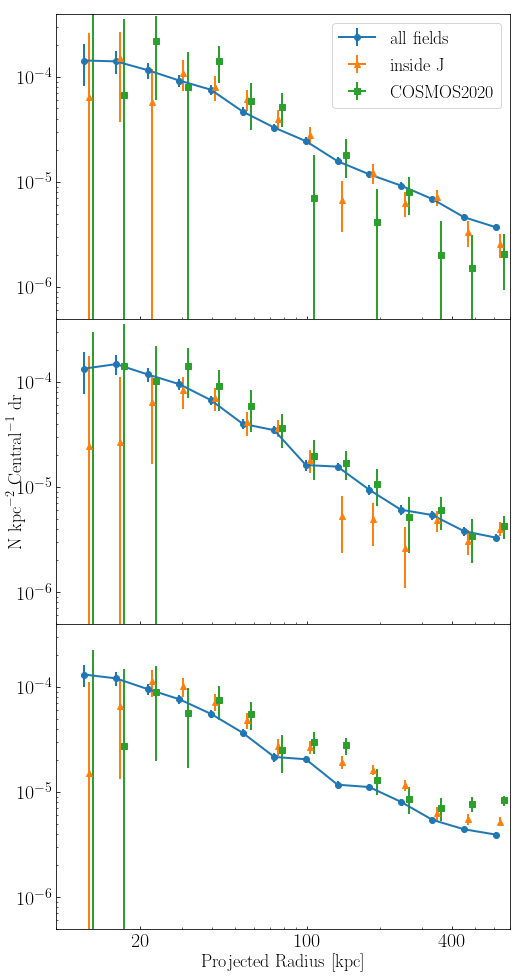

In [23]:
# overlay plot
fig, axs = plt.subplots(3, 1, sharex=True,sharey=True, figsize=(8, 14))
path_list = ['CUT_deep_catalogs/radial_dist_code/distribution/total_sample_sfProb_nuvrk/',
             'CUT_deep_catalogs/radial_dist_code/distribution_test/total_sample_inside_j/',
             'CUT_deep_catalogs/radial_dist_code/distribution_test/total_sample_cosmos2020/']

for i,z in enumerate([0.4, 0.6, 0.8]):
    radial1 = combine_deep_fields(['COSMOS_deep','DEEP_deep','ELAIS_deep','XMM-LSS_deep'],'all','all',masscut_low,masscut_high, z, sat_z_cut=sat_z_cut, path=path_list[0], bin_number=bin_number)
    radial2 = combine_deep_fields(['COSMOS_deep','XMM-LSS_deep'],'all','all',masscut_low,masscut_high, z, sat_z_cut=sat_z_cut, path=path_list[1], bin_number=bin_number)
    radial3 = combine_deep_fields(['COSMOS2020'],'all','all',masscut_low,masscut_high, z, sat_z_cut=sat_z_cut, path=path_list[2], bin_number=bin_number)
    
    axs[i].errorbar(bin_centers, radial1[0],yerr=radial1[1],xerr=0,fmt='o-',linewidth=2, label='all fields')
    axs[i].errorbar(bin_centers*1.04, radial2[0],yerr=radial2[1],xerr=0,fmt='^',linewidth=2,label='inside J')
    axs[i].errorbar(bin_centers*1.04**2, radial3[0],yerr=radial3[1],xerr=0,fmt='s',linewidth=2,label='COSMOS2020')

axs[0].legend(fontsize=18)
axs[0].set_yscale('log')
axs[0].set_xscale('log')
axs[0].set_xticks([20, 100, 400])
axs[0].get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
axs[0].set_xlim([9,700])
axs[0].set_ylim([5e-7,4e-4])

fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
plt.xlabel('Projected Radius [kpc]', fontsize=18)
plt.ylabel('N kpc$^{-2}$ Central$^{-1}$ dr', fontsize=18)
plt.tight_layout()
fig.subplots_adjust(hspace=0)
fig.subplots_adjust(wspace=0)
plt.show() 

#### fig.9 and 10 (inside j)
redshift evolution plots with inside_j objects

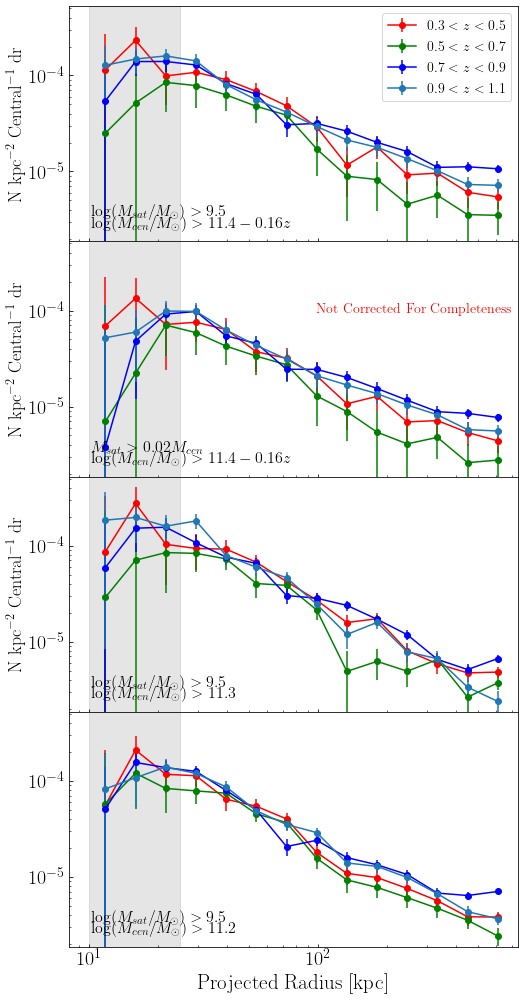

In [9]:
fig, axs = plt.subplots(4, 1, sharex=True,sharey=True, figsize=(7.5, 14))
sfq_method = 'sfProb_nuvrk'
sat_z_cut = 3.0
field_names =  ['COSMOS_deep','XMM-LSS_deep']

########### panel 1: moving cut on centrals. fixed cut on satellites
path = 'CUT_deep_catalogs/radial_dist_code/distribution_test/total_sample_'+sfq_method+'_evo_cenmass_inside_j/'   # evolving mass cut
bin_centers = np.load(path+'bin_centers_fixed.npy')
radial_4 = combine_deep_fields(field_names,'all','all','9.5','12.0', 0.4, sat_z_cut=sat_z_cut, path=path)
radial_6 = combine_deep_fields(field_names,'all','all','9.5','12.0', 0.6, sat_z_cut=sat_z_cut, path=path)
radial_8 = combine_deep_fields(field_names,'all','all','9.5','12.0', 0.8, sat_z_cut=sat_z_cut, path=path)
radial_10 = combine_deep_fields(field_names,'all','all','9.5','12.0', 1.0, sat_z_cut=sat_z_cut, path=path)
axs[0].errorbar(bin_centers, radial_4[0],yerr=radial_4[1],fmt='or-',label='$0.3<z<0.5$')
axs[0].errorbar(bin_centers, radial_6[0],yerr=radial_6[1],fmt='og-',label='$0.5<z<0.7$')
axs[0].errorbar(bin_centers, radial_8[0],yerr=radial_8[1],fmt='ob-',label='$0.7<z<0.9$')
axs[0].errorbar(bin_centers, radial_10[0],yerr=radial_10[1],fmt='o-',label='$0.9<z<1.1$')
axs[0].axvspan(10, 25, alpha=0.1, color='k')
axs[0].legend(fontsize=14)

########### panel 2: moving cut on centrals and satellites
path =  'CUT_deep_catalogs/radial_dist_code/distribution_test/total_sample_'+sfq_method+'_evo_cenmass_inside_j/'  # evolving mass cut
radial_4 = combine_deep_fields(field_names,'all','all','0.02','0.99', 0.4, sat_z_cut=sat_z_cut, path=path)
radial_6 = combine_deep_fields(field_names,'all','all','0.02','0.99', 0.6, sat_z_cut=sat_z_cut, path=path)
radial_8 = combine_deep_fields(field_names,'all','all','0.02','0.99', 0.8, sat_z_cut=sat_z_cut, path=path)
radial_10 = combine_deep_fields(field_names,'all','all','0.02','0.99', 1.0, sat_z_cut=sat_z_cut, path=path)
axs[1].errorbar(bin_centers, radial_4[0],yerr=radial_4[1],fmt='or-',label='$0.3<z<0.5$')
axs[1].errorbar(bin_centers, radial_6[0],yerr=radial_6[1],fmt='og-',label='$0.5<z<0.7$')
axs[1].errorbar(bin_centers, radial_8[0],yerr=radial_8[1],fmt='ob-',label='$0.7<z<0.9$')
axs[1].errorbar(bin_centers, radial_10[0],yerr=radial_10[1],fmt='o-',label='$0.9<z<1.1$')
axs[1].annotate('Not Corrected For Completeness',xy=([0.55,0.7]),xycoords='axes fraction',fontsize=14,color='r')
axs[1].axvspan(10, 25, alpha=0.1, color='k')

########### panel 3: fixed cuts for centrals and satellites
path = 'CUT_deep_catalogs/radial_dist_code/distribution_test/total_sample_'+sfq_method+'_inside_j/'  # evolving mass cut
radial_4 = combine_deep_fields(field_names,'all','all','9.5','12.0', 0.4, sat_z_cut=sat_z_cut, path=path)
radial_6 = combine_deep_fields(field_names,'all','all','9.5','12.0', 0.6, sat_z_cut=sat_z_cut, path=path)
radial_8 = combine_deep_fields(field_names,'all','all','9.5','12.0', 0.8, sat_z_cut=sat_z_cut, path=path)
radial_10 = combine_deep_fields(field_names,'all','all','9.5','12.0', 1.0, sat_z_cut=sat_z_cut, path=path)
axs[2].errorbar(bin_centers, radial_4[0],yerr=radial_4[1],fmt='or-',label='$0.3<z<0.5$')
axs[2].errorbar(bin_centers, radial_6[0],yerr=radial_6[1],fmt='og-',label='$0.5<z<0.7$')
axs[2].errorbar(bin_centers, radial_8[0],yerr=radial_8[1],fmt='ob-',label='$0.7<z<0.9$')
axs[2].errorbar(bin_centers, radial_10[0],yerr=radial_10[1],fmt='o-',label='$0.7<z<0.9$')
axs[2].axvspan(10, 25, alpha=0.1, color='k')

########### panel 4: fixed cuts for centrals and satellites
path = 'CUT_deep_catalogs/radial_dist_code/distribution_test/total_sample_'+sfq_method+'_inside_j_112/'  # evolving mass cut
radial_4 = combine_deep_fields(field_names,'all','all','9.5','12.0', 0.4, sat_z_cut=sat_z_cut, path=path)
radial_6 = combine_deep_fields(field_names,'all','all','9.5','12.0', 0.6, sat_z_cut=sat_z_cut, path=path)
radial_8 = combine_deep_fields(field_names,'all','all','9.5','12.0', 0.8, sat_z_cut=sat_z_cut, path=path)
radial_10 = combine_deep_fields(field_names,'all','all','9.5','12.0', 1.0, sat_z_cut=sat_z_cut, path=path)
axs[3].errorbar(bin_centers, radial_4[0],yerr=radial_4[1],fmt='or-',label='$0.3<z<0.5$')
axs[3].errorbar(bin_centers, radial_6[0],yerr=radial_6[1],fmt='og-',label='$0.5<z<0.7$')
axs[3].errorbar(bin_centers, radial_8[0],yerr=radial_8[1],fmt='ob-',label='$0.7<z<0.9$')
axs[3].errorbar(bin_centers, radial_10[0],yerr=radial_10[1],fmt='o-',label='$0.7<z<0.9$')
axs[3].axvspan(10, 25, alpha=0.1, color='k')

# annotations
axs[3].annotate('$\log(M_{cen}/M_\odot)>11.2$',xy=([0.05,0.05]),xycoords='axes fraction',fontsize=16,color='k')
axs[2].annotate('$\log(M_{cen}/M_\odot)>11.3$',xy=([0.05,0.05]),xycoords='axes fraction',fontsize=16,color='k')
axs[1].annotate('$\log(M_{cen}/M_\odot)>11.4-0.16z$',xy=([0.05,0.05]),xycoords='axes fraction',fontsize=16,color='k')
axs[0].annotate('$\log(M_{cen}/M_\odot)>11.4-0.16z$',xy=([0.05,0.05]),xycoords='axes fraction',fontsize=16,color='k')

axs[3].annotate('$\log(M_{sat}/M_\odot)>9.5$',xy=([0.05,0.1]),xycoords='axes fraction',fontsize=16,color='k')
axs[2].annotate('$\log(M_{sat}/M_\odot)>9.5$',xy=([0.05,0.1]),xycoords='axes fraction',fontsize=16,color='k')
axs[1].annotate('$M_{sat}>0.02M_{cen}$',xy=([0.05,0.1]),xycoords='axes fraction',fontsize=16,color='k')
axs[0].annotate('$\log(M_{sat}/M_\odot)>9.5$',xy=([0.05,0.1]),xycoords='axes fraction',fontsize=16,color='k')

plt.xscale('log')
plt.yscale('log')
plt.xlabel('Projected Radius [kpc]', fontsize=21)
axs[0].set_ylabel('N kpc$^{-2}$ Central$^{-1}$ dr',fontsize=18)
axs[1].set_ylabel('N kpc$^{-2}$ Central$^{-1}$ dr',fontsize=18)
axs[2].set_ylabel('N kpc$^{-2}$ Central$^{-1}$ dr',fontsize=18)
plt.tight_layout()
fig.subplots_adjust(hspace=0)
fig.subplots_adjust(wspace=0)

/Users/lejay/anaconda3/lib/python3.6/site-packages/numpy/ma/core.py:6649: RuntimeWarning: overflow encountered in power
  result = np.where(m, fa, umath.power(fa, fb)).view(basetype)


Text(0.5, 0, 'Projected Radius [kpc]')

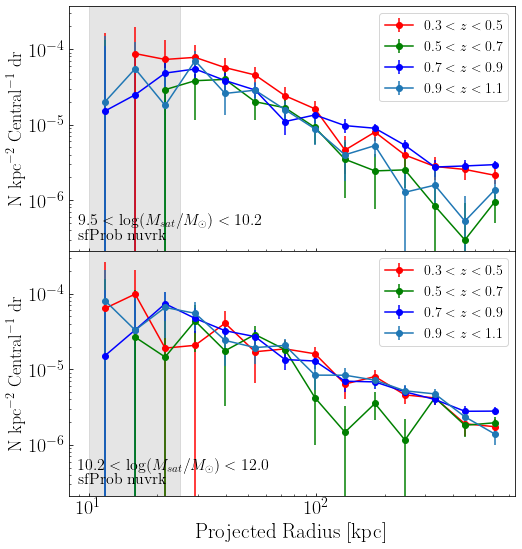

In [31]:
fig, axs = plt.subplots(2, 1, sharex=True,sharey=True, figsize=(8, 9))
path = 'CUT_deep_catalogs/radial_dist_code/distribution_test/split_mass_sfProb_nuvrk_inside_j/'
sfq_method = 'sfProb_nuvrk'

sat_z_cut = 3.0
bin_centers = np.load(path+'bin_centers_fixed.npy')
masscut_lows = ['9.5','10.2']
masscut_highs = ['10.2','12.0']
colors = ['r','g','b','']
for i in range(2):
    for k,z in enumerate([0.4,0.6,0.8,1.0]):
        radial = combine_deep_fields(field_names,'all','all',masscut_lows[i],masscut_highs[i], z, sat_z_cut=sat_z_cut, path=path)
        axs[i].errorbar(bin_centers, radial[0],yerr=radial[1],fmt='o'+colors[k]+'-',label=r'$'+str(round(z-0.1,1))+'<z<'+str(round(z+0.1,1))+'$')
        
    axs[i].annotate(sfq_method.replace('_',' '),xy=([0.02,0.05]),xycoords='axes fraction',fontsize=16,color='k')
    axs[i].annotate('$'+masscut_lows[i]+'<\log(M_{sat}/M_\odot)<'+masscut_highs[i]+'$',xy=([0.02,0.1]),xycoords='axes fraction',fontsize=16,color='k')
    
    axs[i].axhline(2e-5,10,700,linewidth=4, color='r')
    axs[i].axvspan(10, 25, alpha=0.1, color='k')
    axs[i].legend(fontsize=14)
    axs[i].set_ylabel('N kpc$^{-2}$ Central$^{-1}$ dr',fontsize=18)
    plt.xscale('log')
    plt.yscale('log')

fig.subplots_adjust(hspace=0)
fig.subplots_adjust(wspace=0)
plt.xlabel('Projected Radius [kpc]', fontsize=21)

#### compare radial number density across sfq_methods

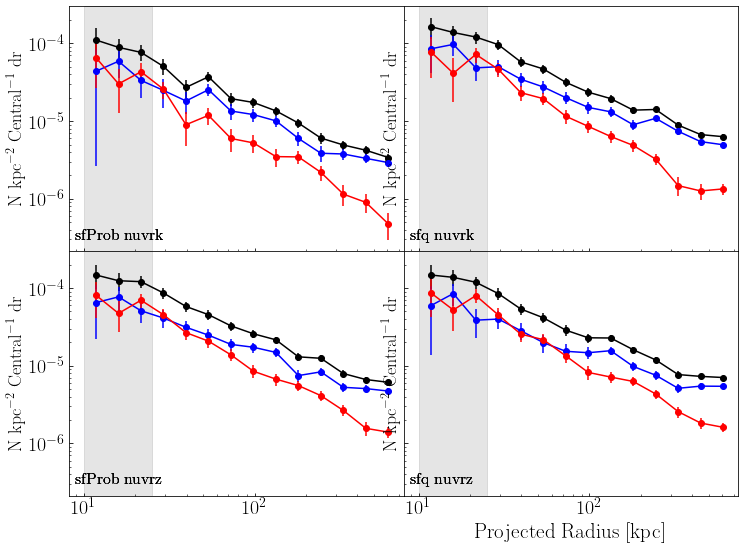

In [44]:
# 2x2 panels
fig, axs = plt.subplots(2, 2, sharex=True,sharey=True, figsize=(12, 9))
sfq_methods = ['sfProb_nuvrk','sfq_nuvrk','sfProb_nuvrz','sfq_nuvrz']
sat_z_cut = 3.0
bin_centers = np.load(path+'bin_centers_fixed.npy')
colors = ['k','b','r']

for i,sfq_method in enumerate(sfq_methods):
    path = 'CUT_deep_catalogs/radial_dist_code/distribution/total_sample_'+sfq_method+'/'
    row=i//2; col=i%2
    
    count_radial_allz = load_deep('COSMOS_deep', 'all', 'all', '9.5','12.0', sat_z_cut, z, path=path, sample='')
    count_radial_sf_allz = load_deep('COSMOS_deep', 'all', 'ssf', '9.5','12.0', sat_z_cut, z, path=path, sample='')
    count_radial_q_allz = load_deep('COSMOS_deep', 'all', 'sq', '9.5','12.0', sat_z_cut, z, path=path, sample='')
    for k, radial in enumerate([count_radial_allz,count_radial_sf_allz,count_radial_q_allz]):
        axs[row][col].errorbar(bin_centers, radial[0],yerr=radial[1],fmt='o'+colors[k]+'-')
        axs[row][col].annotate(sfq_method.replace('_',' '),xy=([0.02,0.05]),xycoords='axes fraction',fontsize=16,color='k')
    
    axs[row][col].axhline(2e-5,10,700,linewidth=4, color='r')
    axs[row][col].axvspan(10, 25, alpha=0.1, color='k')
    axs[row][col].set_ylabel('N kpc$^{-2}$ Central$^{-1}$ dr',fontsize=18)
    plt.xscale('log')
    plt.yscale('log')

fig.subplots_adjust(hspace=0)
fig.subplots_adjust(wspace=0)
plt.xlabel('Projected Radius [kpc]', fontsize=21)
plt.show()

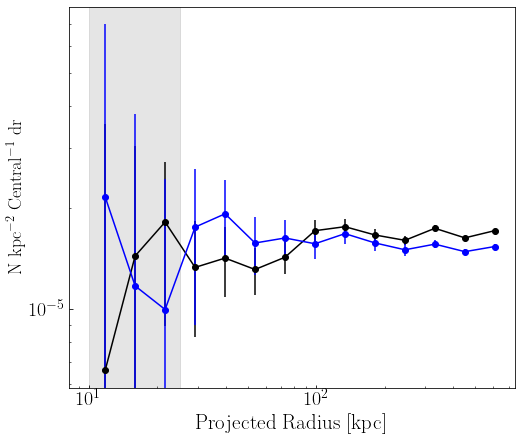

In [3]:
# compare bkg levels between inside_j and all fields

fig, ax = plt.subplots(1, 1, sharex=True,sharey='row', figsize=(8, 7))
z=0.4
sat_z_cut=3.0
sample = 'bkg'

# inside_j
field_names = ['COSMOS_deep','XMM-LSS_deep']
path = 'CUT_deep_catalogs/radial_dist_code/distribution_test/total_sample_sfProb_nuvrk_inside_j_bkg_test/'
bin_centers = np.load(path+'bin_centers_fixed.npy')
radial = combine_deep_fields(field_names,'all','all','9.5','12.0', 0.4, sat_z_cut=sat_z_cut, path=path,sample=sample)
ax.errorbar(bin_centers, radial[0],yerr=radial[1],fmt='ok-')

# all_fields
field_names = ['COSMOS_deep','XMM-LSS_deep']
path = 'CUT_deep_catalogs/radial_dist_code/distribution_test/total_sample_sfProb_nuvrk_bkg_test/'
bin_centers = np.load(path+'bin_centers_fixed.npy')
radial = combine_deep_fields(field_names,'all','all','9.5','12.0', 0.4, sat_z_cut=sat_z_cut, path=path,sample=sample)
ax.errorbar(bin_centers, radial[0],yerr=radial[1],fmt='ob-')

ax.axhline(2e-5,10,700,linewidth=4, color='r')
ax.axvspan(10, 25, alpha=0.1, color='k')
ax.set_ylabel('N kpc$^{-2}$ Central$^{-1}$ dr',fontsize=18)
ax.set_xlabel('Projected Radius [kpc]', fontsize=21)
plt.xscale('log')
plt.yscale('log')

#### moving $\sigma_z$

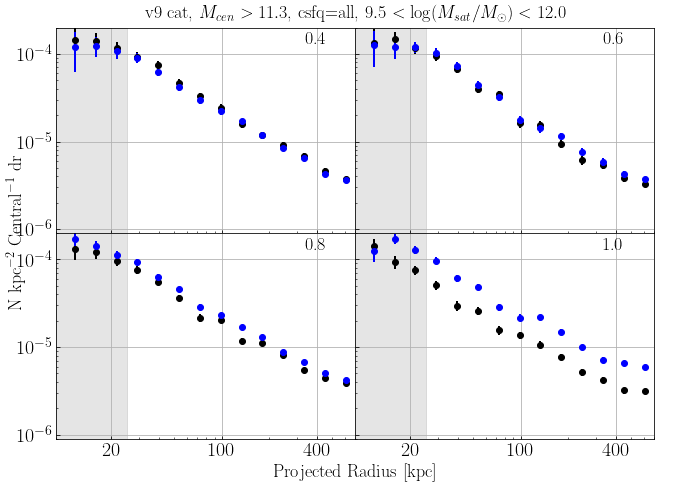

In [38]:
fig, axs = plt.subplots(2, 2, sharex=True, sharey=True, figsize=(10,7))
sample_all=''
csfq='all'
sat_z_cut = 3.0
field_names = ['ELAIS_deep','DEEP_deep','COSMOS_deep','XMM-LSS_deep']
colors = ['k','b']
#============= primary data ===========
path1 = 'CUT_deep_catalogs/radial_dist_code/distribution/total_sample_sfProb_nuvrk/' 
path2 = 'CUT_deep_catalogs/radial_dist_code/distribution_test/total_sample_sfProb_nuvrk_moving_z_sig/' 
sample_name = r'v9 cat, $M_{cen}>11.3$, csfq='+csfq+', $9.5<\log(M_{sat}/M_\odot)<12.0$'

for i,z in enumerate([0.4,0.6,0.8,1.0]):
    row = i // 2; col = i % 2
    for k,path in enumerate([path1, path2]):
        count_radial = combine_deep_fields(field_names, csfq, 'all','9.5','12.0',z,path,sat_z_cut=sat_z_cut,sample=sample_all)
        bin_edges = np.load(path+'bin_centers_fixed.npy')
        #==============plot====================
        axs[row][col].errorbar(bin_edges, count_radial[0],count_radial[1],fmt='o'+colors[k],label=' $'+str(round(z-0.1,1))+'<z<'+str(round(z+0.1,1))+'$',linewidth=2)
        axs[row][col].set_yscale('log')
        axs[row][col].set_xscale('log')
    axs[row][col].axvspan(9, 25, alpha=0.1, color='k')
    axs[row][col].set_xticks([20, 100, 400])
    axs[row][col].get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
    axs[row][col].set_xlim([9,700])
    axs[row][col].set_ylim([9e-7,2e-4])
    axs[row][col].grid()
    axs[row][col].annotate(z,xy=([0.83,0.92]),xycoords='axes fraction',fontsize=18)
fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
plt.xlabel('Projected Radius [kpc]', fontsize=18)
plt.ylabel('N kpc$^{-2}$ Central$^{-1}$ dr', fontsize=18)
plt.tight_layout()
plt.title(sample_name,fontsize=18)
fig.subplots_adjust(hspace=0)
fig.subplots_adjust(wspace=0)
plt.show() 

#### v11 6B

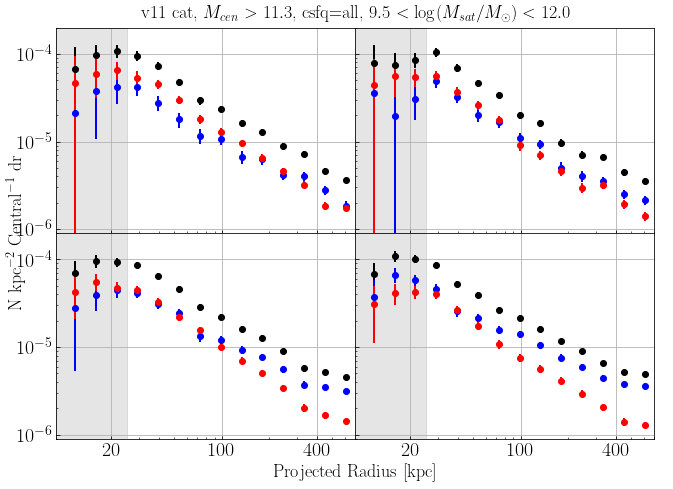

In [5]:
fig, axs = plt.subplots(2, 2, sharex=True, sharey=True, figsize=(10,7))
sample_all=''
csfq='all'
sat_z_cut = 3.0
field_names = ['ELAIS_deep','DEEP_deep','COSMOS_deep','XMM-LSS_deep']
colors = ['k','b','r']
#============= primary data ===========
path = 'CUT_deep_catalogs/radial_dist_code/distribution_test/total_sample_sfProb_nuvrk_v11_6b_v11_6b/' 
sample_name = r'v11 cat, $M_{cen}>11.3$, csfq='+csfq+', $9.5<\log(M_{sat}/M_\odot)<12.0$'

for i,z in enumerate([0.4,0.6,0.8,1.0]):
    row = i // 2; col = i % 2
    for k,ssfq in enumerate(['all','ssf','sq']):
        count_radial = combine_deep_fields(field_names, csfq, ssfq,'9.5','12.0',z,path,sat_z_cut=sat_z_cut,sample=sample_all)
        bin_edges = np.load(path+'bin_centers_fixed.npy')
        #==============plot====================
        axs[row][col].errorbar(bin_edges, count_radial[0],count_radial[1],fmt='o'+colors[k],
                           label=ssfq+' $'+str(round(z-0.1,1))+'<z<'+str(round(z+0.1,1))+'$',linewidth=2)
        axs[row][col].set_yscale('log')
        axs[row][col].set_xscale('log')
    axs[row][col].axvspan(9, 25, alpha=0.1, color='k')
    axs[row][col].set_xticks([20, 100, 400])
    axs[row][col].get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
    axs[row][col].set_xlim([9,700])
    axs[row][col].set_ylim([9e-7,2e-4])
    axs[row][col].grid()
fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
plt.xlabel('Projected Radius [kpc]', fontsize=18)
plt.ylabel('N kpc$^{-2}$ Central$^{-1}$ dr', fontsize=18)
plt.tight_layout()
plt.title(sample_name,fontsize=18)
fig.subplots_adjust(hspace=0)
fig.subplots_adjust(wspace=0)
plt.show() 


direct complarison sf/q satellite split v9 and v11

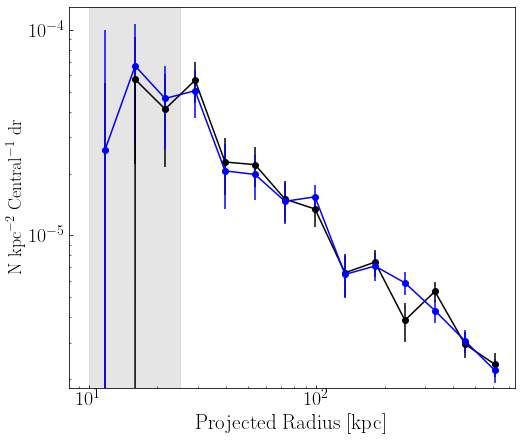

In [8]:
fig, ax = plt.subplots(1, 1, sharex=True,sharey='row', figsize=(8, 7))
z=0.4
sat_z_cut=3.0
sample = ''

field_names = ['COSMOS_deep','XMM-LSS_deep']
path = 'CUT_deep_catalogs/radial_dist_code/distribution_test/total_sample_sfProb_nuvrk_v11_6b_v11_6b/'
bin_centers = np.load(path+'bin_centers_fixed.npy')
radial = combine_deep_fields(field_names,'all','ssf','9.5','12.0', 0.4, sat_z_cut=sat_z_cut, path=path,sample=sample)
ax.errorbar(bin_centers, radial[0],yerr=radial[1],fmt='ok-')

field_names = ['COSMOS_deep','XMM-LSS_deep']
path = 'CUT_deep_catalogs/radial_dist_code/distribution/total_sample_sfProb_nuvrk/'
bin_centers = np.load(path+'bin_centers_fixed.npy')
radial = combine_deep_fields(field_names,'all','ssf','9.5','12.0', 0.4, sat_z_cut=sat_z_cut, path=path,sample=sample)
ax.errorbar(bin_centers, radial[0],yerr=radial[1],fmt='ob-')

ax.axhline(2e-5,10,700,linewidth=4, color='r')
ax.axvspan(10, 25, alpha=0.1, color='k')
ax.set_ylabel('N kpc$^{-2}$ Central$^{-1}$ dr',fontsize=18)
ax.set_xlabel('Projected Radius [kpc]', fontsize=21)
plt.xscale('log')
plt.yscale('log')

#### @$z\sim1.5$

14 15 14 14
nfw+sersic [1.000e+03 3.514e-06 1.276e-05 4.813e+01 6.161e-01] [4.800e+02 1.283e-06 3.382e-06 8.667e+00 4.370e-01] 0.2555152805710961
14 15 14 14
nfw+sersic [1.000e+03 2.405e-06 7.345e-06 4.611e+01 3.481e-01] [5.016e+02 8.907e-07 2.501e-06 9.080e+00 3.528e-01] 0.2684493385134688
14 15 14 14
nfw+sersic [1.000e+03 9.958e-07 3.343e-06 7.200e+01 1.375e+00] [2.579e+03 2.240e-06 3.886e-06 7.807e+01 1.963e+00] 0.19565960555220463


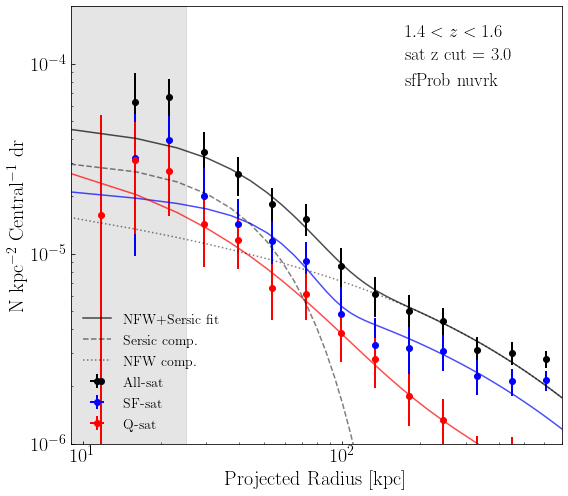

In [18]:
fig, axs = plt.subplots(1, 1, sharex=True,sharey='row', figsize=(8, 7))
sfq_method = 'sfProb_nuvrk'
path = 'CUT_deep_catalogs/radial_dist_code/distribution_test/total_sample_sfProb_nuvrk_bkg_test/'

masscut_low = '9.5'
masscut_high = '12.0'
csfq='all'
sat_z_cut = 3.0
z='1.5'
start=4
color=['k','b','r']
sat_type = ['All','SF','Q']
fit_x = np.linspace(2,700,num=100)
bin_edges = np.load(path+'bin_edges.npy')
bin_centers = np.load(path+'bin_centers_fixed.npy')

# load in data
count_radial_allz = combine_deep_fields(field_names, csfq, 'all',masscut_low,masscut_high,z,path,sat_z_cut=sat_z_cut,sample=sample_all)
count_radial_sf_allz = combine_deep_fields(field_names, csfq, 'ssf',masscut_low,masscut_high,z,path,sat_z_cut=sat_z_cut,sample=sample_all)
count_radial_q_allz = combine_deep_fields(field_names, csfq, 'sq',masscut_low,masscut_high,z,path,sat_z_cut=sat_z_cut,sample=sample_all)

######## plot
for i, radial in enumerate([count_radial_allz,count_radial_sf_allz,count_radial_q_allz]):
    label='NFW+Sersic fit' if i==0 else ''
    print(len(bin_centers),len(bin_edges),len(radial[0]),len(radial[1]))
    plt.errorbar(bin_centers, radial[0],yerr=radial[1],xerr=0,fmt='o'+color[i],label=sat_type[i]+'-sat',linewidth=2)
    
    popt_allz,pcov_allz,chi2_allz = fit_nfw_sersic(bin_centers,radial[0],radial[1], 4)
    perr_allz = np.sqrt(np.diag(pcov_allz))
    print('nfw+sersic',popt_allz,perr_allz,chi2_allz/(len(bin_edges)-start+1 - len(popt_allz)))
    plt.plot(fit_x,nfw_sersic(fit_x, popt_allz[0],popt_allz[1],popt_allz[2],popt_allz[3],popt_allz[4]),color[i],alpha=0.7,label=label)
        
popt_allz,pcov_allz,chi2_allz = fit_nfw_sersic(bin_centers,count_radial_allz[0],count_radial_allz[1], 4)
plt.plot(fit_x,sersic(fit_x, popt_allz[2],popt_allz[3],popt_allz[4]),'--k',alpha=0.5,label='Sersic comp.')
plt.plot(fit_x,nfw(fit_x,popt_allz[0],popt_allz[1]),':k',alpha=0.5,label='NFW comp.')
plt.annotate(r'$1.4<z<1.6$',xy=([0.68,0.93]),xycoords='axes fraction',fontsize=18,color='k')
plt.annotate('sat z cut = '+str(sat_z_cut),xy=([0.68,0.88]),xycoords='axes fraction',fontsize=18,color='k')
plt.annotate(sfq_method.replace('_',' '),xy=([0.68,0.82]),xycoords='axes fraction',fontsize=18,color='k')

plt.axvspan(9, 25, alpha=0.1, color='k')
plt.xscale('log')
plt.yscale('log')
plt.xlim([9,700])
plt.ylim([1e-6,2e-4])
plt.xlabel('Projected Radius [kpc]', fontsize=20)
plt.ylabel('N kpc$^{-2}$ Central$^{-1}$ dr', fontsize=20)
plt.legend(fontsize=14,frameon=False,loc='lower left')
plt.tight_layout()